# Анализ данных сервиса аренды самокатов GoFast с целью принятий решений, которые могут помочь бизнесу вырасти

*Цель проекта:*

Были получены данные о пользователях сервиса из нескольких городов, а также об их поездках. Нам нужно проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

*План исследования:*

- Изучение общей информаци
- Подготовка данных
- Исследовательский анализ данных
- Проверка гипотез
- Выведение общего вывода, подведение итогов исследования и выработка параметров для сервиса на основе полученных результатов



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from math import factorial
from math import sqrt

#### Шаг 1. Загрузка данных

In [3]:
#загружаем все датасеты и срзу переводим в даты то, что могло быть датами, но сейчас не принадлежит к этому типу
df_users = pd.read_csv("/datasets/users_go.csv")
df_rides = pd.read_csv("/datasets/rides_go.csv", parse_dates=['date'])
df_subs = pd.read_csv("/datasets/subscriptions_go.csv")

#### Шаг 2. Предобработка данных

In [4]:
#посмотрим на них, на инфо и форму
df_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [5]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [6]:
df_rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [7]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [8]:
df_subs

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [9]:
df_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [10]:
#првоерим, что пропусков нет
print(df_users.isna().sum())
print(df_rides.isna().sum())
print(df_subs.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
user_id     0
distance    0
duration    0
date        0
dtype: int64
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


In [11]:
#првоерим наличие дубликатов
print(df_users.duplicated().sum())
print(df_rides.duplicated().sum())
print(df_subs.duplicated().sum())

31
0
0


**Общее инфо и базовое описание данных**

В датасете df_users есть колонки с инфо об именах пользователей, их возрасте, городе и подписке на сервис.

- user_id	уникальный идентификатор пользователя
- name - имя пользователя
- age - возраст
- city - город
- subscription_type - тип подписки (free, ultra)


В датасете df_rides есть колонки о пользователях, их поездках (расстоянии, дате и продолжительности) и подписках.

- user_id	- уникальный идентификатор пользователя
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date - дата совершения поездки

В датасете df_subs содержится инфо о самих подписках.

- subscription_type	- тип подписки
- minute_price - стоимость одной минуты поездки по данной подписке
- start_ride_price - стоимость начала поездки
- subscription_fee - стоимость ежемесячного платежа

**Промежуточный вывод для дальнейшей предобработки данных**

По датасетам увидели, что:

- пропусков нет ни в одном из столбцов ни в одном датасете
- есть 31 явный дубликат в таблице rides - *разберемся ниже*
- названия колонок везде читаемы, ничего трогать не надо

In [12]:
#удаляем дубликаты из df_rides
df_users= df_users.drop_duplicates()
df_users.duplicated().sum()

0

In [13]:
#создадим новую колонку с номерами месяцев в df_rides и сразу проверим
df_rides['month'] = df_rides['date'].dt.month
df_rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [14]:
min_date = df_rides['date'].min()
max_date = df_rides['date'].max()

print(f"Самая ранняя дата: {min_date}")
print(f"Самая поздняя дата: {max_date}")

Самая ранняя дата: 2021-01-01 00:00:00
Самая поздняя дата: 2021-12-30 00:00:00


*Получается, что данные собраны для 2021 год*

**Промежуточный вывод по предобработке данных**

- Дубликатов было мало - 31 штука. Они были удалены. Датасет большой, на результаты удаление вряд ли повлияет.

- Отсуствующих значений не обнаружено.

- Формат данных был изменен для дат, столбец с месяцами был добавлен.

#### Шаг 3. Исследовательский анализ данных

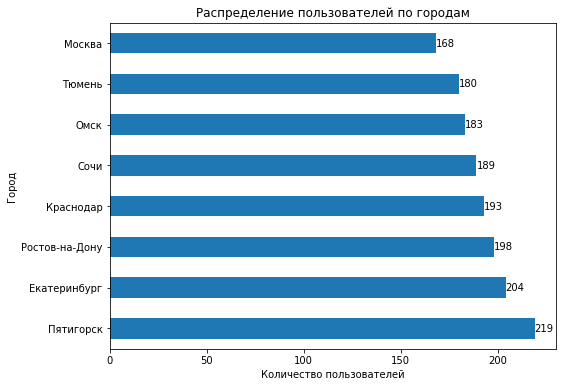

In [15]:
#визуализируем частоту встречаемости городов. Сразу поставим цифры, чтобы понятнее было
ax = df_users["city"].value_counts().plot.barh(figsize=(8, 6))
plt.title("Распределение пользователей по городам")
plt.xlabel("Количество пользователей")
plt.ylabel("Город")


for p in ax.patches:
    ax.annotate(str(int(p.get_width())), (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center')

plt.show()

In [16]:
#Посмотрим, сколько пользователей в каждом городе на процентах
city_counts = df_users["city"].value_counts()
total_users = city_counts.sum()

city_percentages = (city_counts / total_users) * 100


result_df = pd.DataFrame({'City Counts': city_counts, 'Percentage': city_percentages})

print(city_percentages)

Пятигорск         14.276402
Екатеринбург      13.298566
Ростов-на-Дону    12.907432
Краснодар         12.581486
Сочи              12.320730
Омск              11.929596
Тюмень            11.734029
Москва            10.951760
Name: city, dtype: float64


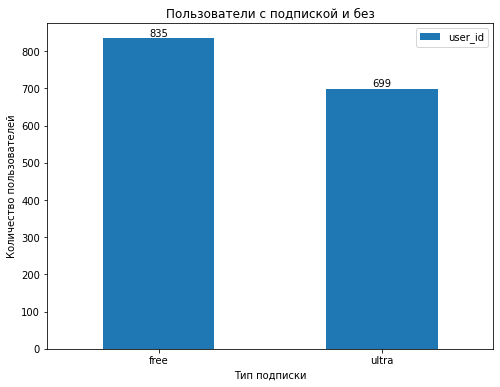

In [53]:
#оценим соотношение пользователей с подпиской и без подписки
pivot_table = df_users.pivot_table(index='subscription_type', values='user_id', aggfunc='count')

# Создайте график
ax = pivot_table.plot(kind='bar', figsize=(8, 6), rot=0)

ax.set_title("Пользователи с подпиской и без")
ax.set_xlabel("Тип подписки")
ax.set_ylabel("Количество пользователей")
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

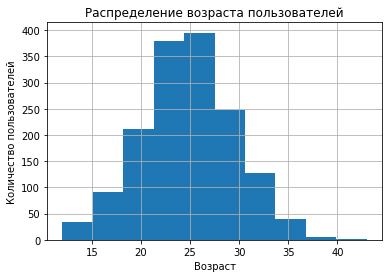

In [18]:
#оценим распределение возрастов
df_users["age"].hist()
plt.title("Распределение возраста пользователей")
plt.xlabel("Возраст")
plt.ylabel("Количество пользователей")

plt.show()

Распределение - нормальное

посмотрим точнее, сколько каких возрастов встречается. Визуализируем таблицу чистот

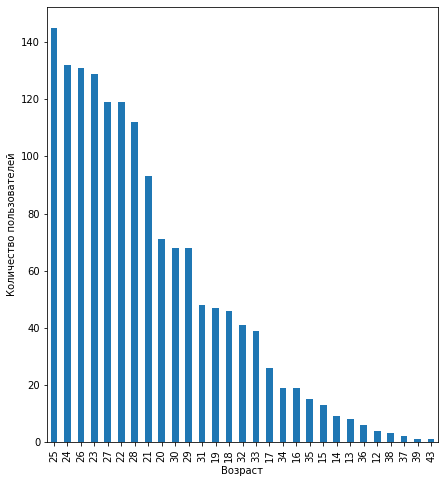

In [19]:
x = df_users["age"].value_counts().plot.bar(figsize=(7, 8))
x.set_xlabel("Возраст")
x.set_ylabel("Количество пользователей")
x.set_ylabel("Количество пользователей")

plt.show()

In [20]:
#Приступим к анализу показателей df_rides для определения распределений
df_rides.describe()

,user_id,distance,duration,month
count,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011,6.486772
std,434.734317,1116.831209,6.091051,3.437410
min,1.000000,0.855683,0.500000,1.000000
25%,487.000000,2543.226360,13.597563,4.000000
50%,889.000000,3133.609994,17.678395,6.000000
75%,1213.250000,3776.222735,21.724800,9.000000
max,1534.000000,7211.007745,40.823963,12.000000


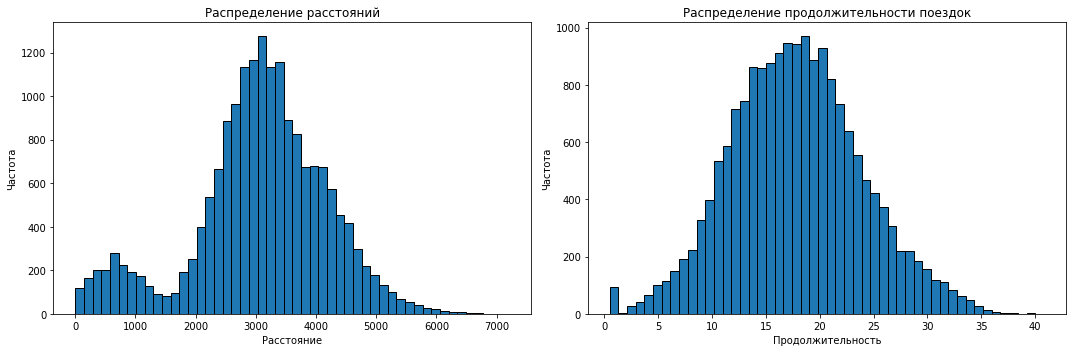

In [21]:
#построим гистограммы по distance и duration в таблице df_rides и на всякий случай по возрасту df_users.
#Посмотрим, есть ли там аномалии или странные значения
#начнем с distance и duration в таблице df_rides

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(df_rides["distance"], bins=50, edgecolor='k')
ax1.set_title("Распределение расстояний")
ax1.set_xlabel("Расстояние")
ax1.set_ylabel("Частота")


ax2.hist(df_rides["duration"], bins=50, edgecolor='k')
ax2.set_title("Распределение продолжительности поездок")
ax2.set_xlabel("Продолжительность")
ax2.set_ylabel("Частота")

plt.tight_layout()

plt.show()

Судя по графикам и инфо о показателях, расстояние  и продолжительность распределны нормально, расстояние тоже близко к нормальному, но наблюдаются 2 пика. Возможно, люди доезжает до общественного транспорта или наоборот до дома или раоты с остановки и оставляют самокат.

In [22]:
#Посмотри,сколько было коротких поездок
len(df_rides[df_rides["distance"] < 1500])

1796

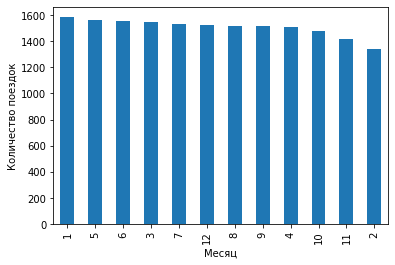

In [23]:
# Теперь посмотрим распределение по месяцам. Визуализируем таблицу частот
ax = df_rides["month"].value_counts().plot.bar()
ax.set_xlabel("Месяц")
ax.set_ylabel("Количество поездок")

plt.show()

**Промежуточный вывод**

Были описаны и визуализированы общие данные о пользователях и поездках:
1) Частота встречаемости городов: больше всего пользователей в Пятигорске (219) и меньше всего в Москве (168). Всего городов 8: Тюмень, Омск, Москва, Ростов-на-Дону, Краснодар, Пятигорск, Екатеринбург, Сочи. Странно, что в Москве меньше, а в Тюмени больше. В Москве только 10% от всех, а в Тюмени - 14%. В Пятигорске на 30% больше пользователей чем в Москве, и это вызывает вопросы для бизнеса, почему столь разные города имеют такую разницу и не в пользу Москвы.

2) Соотношение пользователей с подпиской и без подписки: 835 с подпиской, 699 без подписки.

3) Возраст пользователей: распределён от 12 до 43. Больше всего клиентов в возрасте от 20 до 30 лет. Меньше всего самых взрослых и самых молодых: до 15 и от 37 до 43.

4) Расстояние, которое пользователь преодолел за одну поездку, имеет 2 пика: один от 0 до 1500 метров (около 1800 значений), и остальная часть от 1500 до 6000 метров. Распределены нормально.

5) Продолжительность поездок распределена нормально. Среднее лежит в районе 18 минут.

6) Почему-то в январе поездок больше, чем в летние месяцы. Нужно уточнить у заказчика. 

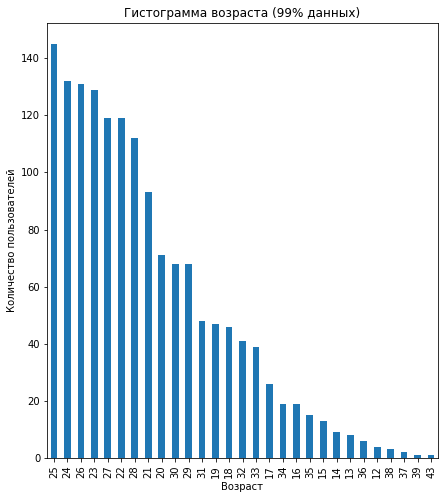

In [24]:
# Отсечем 1% самых редких значений в столбце с возрастом
q1 = df_users["age"].quantile(0.01)
q3 = df_users["age"].quantile(0.99)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

filtered_age_data = df_users["age"][(df_users["age"] >= lower_bound) & (df_users["age"] <= upper_bound)]

x = filtered_age_data.value_counts().plot.bar(figsize=(7, 8))
x.set_xlabel("Возраст")
x.set_ylabel("Количество пользователей")
plt.title("Гистограмма возраста (99% данных)")
plt.show()

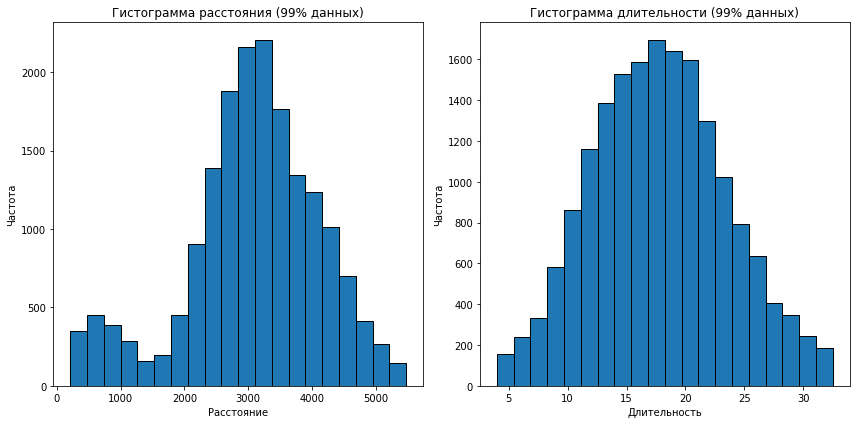

In [25]:
# Отсечем 1% самых редких значений в столбцах с расстоянияем и длительностью поездки и сразу построим графики

q1_distance = df_rides["distance"].quantile(0.01)
q99_distance = df_rides["distance"].quantile(0.99) 


q1_duration = df_rides["duration"].quantile(0.01) 
q99_duration = df_rides["duration"].quantile(0.99) 

filtered_distance_data = df_rides[(df_rides["distance"] >= q1_distance) & (df_rides["distance"] <= q99_distance)]


filtered_duration_data = df_rides[(df_rides["duration"] >= q1_duration) & (df_rides["duration"] <= q99_duration)]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(filtered_distance_data["distance"], bins=20, edgecolor='k')
plt.xlabel("Расстояние")
plt.ylabel("Частота")
plt.title("Гистограмма расстояния (99% данных)")

plt.subplot(1, 2, 2)
plt.hist(filtered_duration_data["duration"], bins=20, edgecolor='k')
plt.xlabel("Длительность")
plt.ylabel("Частота")
plt.title("Гистограмма длительности (99% данных)")
plt.tight_layout()
plt.show()


#### Шаг 4. Объединение данных

In [26]:
#Объединим данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуемся методом merge().
merged_df = df_users.merge(df_rides, on='user_id', how='inner')

merged_df = merged_df.merge(df_subs, on='subscription_type', how='inner')

#Проверим
merged_df

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


18068 строк. Значит, ничего не потеряли.

In [27]:
merged_df.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

**Вывод после объединения таблиц**

Объединения таблиц прошло хорошо, данные не были потеряны, пропусков не обнаружено

In [28]:
#Теперь создадим ещё два датафрейма из нового полного датафрейма и сразу проверим из размерность и пропуски в них:
#c данными о пользователях без подписки и с данными о пользователях с подпиской

df_with_subscription = merged_df[merged_df["subscription_type"] == "ultra"]
df_no_subscription = merged_df[merged_df["subscription_type"] == "free"]

print(df_with_subscription.shape)
print(df_no_subscription.shape)
print(df_with_subscription.isna().sum())
print(df_no_subscription.isna().sum())

(6500, 12)
(11568, 12)
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


In [29]:
#проверяем
df_with_subscription.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [30]:
#проверяем
df_no_subscription.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


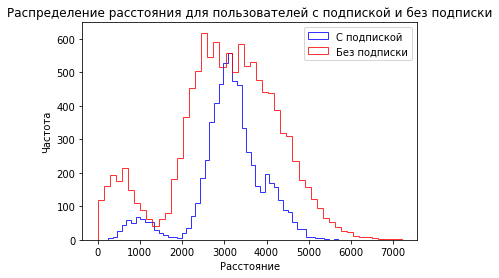

In [31]:
#Теперь визуализируем информацию о расстоянии для пользователей обеих категорий.

%matplotlib inline

plt.hist(df_with_subscription["distance"], bins=50, color='blue', alpha=0.8, label='С подпиской', histtype='step')

plt.hist(df_no_subscription["distance"], bins=50, color='red', alpha=0.8, label='Без подписки', histtype='step')

plt.legend()

plt.xlabel("Расстояние")
plt.ylabel("Частота")
plt.title("Распределение расстояния для пользователей с подпиской и без подписки")

plt.show()

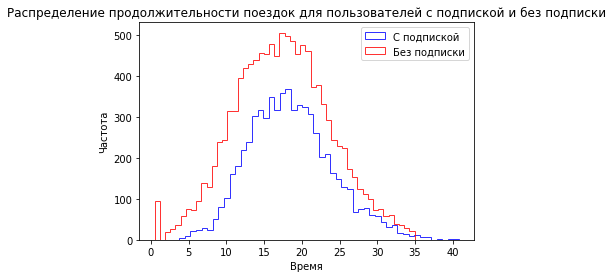

In [32]:
#Теперь визуализируем информацию о продолжительности поездок для пользователей обеих категорий.

%matplotlib inline

plt.hist(df_with_subscription["duration"], bins=50, color='blue', alpha=0.8, label='С подпиской', histtype='step')

plt.hist(df_no_subscription["duration"], bins=50, color='red', alpha=0.8, label='Без подписки', histtype='step')

plt.legend()

plt.xlabel("Время")
plt.ylabel("Частота")
plt.title("Распределение продолжительности поездок для пользователей с подпиской и без подписки")

plt.show()

**Промежуточный вывод**

- Тенденции по времени использованию самокатов и покрытым дистанциям родственны для пользователей с и без подписки, однако есть различия.

#### Шаг 5. Подсчёт выручки

In [33]:
#Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
#сразу округлим, как юыло указано в задаче
merged_df['duration'] = np.ceil(merged_df['duration'])
df_pivot = merged_df.pivot_table(index= ["user_id", "month"], values = ["distance", "duration", "date"],
                                 aggfunc={"distance": "sum", "duration": "sum", "user_id": "count"})

# Переименуем столбцы
df_pivot = df_pivot.rename(columns={"distance": "distance_total",
                                    "duration": "duration_total",
                                    "user_id": "rides_total"})
df_pivot

distance_total  duration_total  rides_total
user_id month                                             
1       1         7027.511294            42.0            2
        4          754.159807             7.0            1
        8         6723.470560            46.0            2
        10        5809.911100            32.0            2
        11        7003.499363            56.0            3
...                       ...             ...          ...
1534    6         3409.468534            26.0            2
        8         7622.453034            48.0            2
        9         4928.173852            23.0            1
        11       13350.015305            78.0            4
        12        2371.711192            16.0            1

[11331 rows x 3 columns]

In [34]:
df_pivot.isna().sum()

distance_total    0
duration_total    0
rides_total       0
dtype: int64

In [35]:
#Подмаппим тип подписки в новый датафрейм для подсчета помесячной стоимости
df_pivot['subscription_type'] = None

# Задаем функцию для определения типа подписки
def determine_subscription_type(user_id):
    return df_users[df_users['user_id'] == user_id]['subscription_type'].values[0]

df_pivot['subscription_type'] = df_pivot.index.get_level_values('user_id').map(determine_subscription_type)
df_pivot_merged = df_pivot.merge(df_subs, on="subscription_type", how="inner" )
df_pivot_merged

,distance_total,duration_total,rides_total,subscription_type,minute_price,start_ride_price,subscription_fee
0,7027.511294,42.0,2,ultra,6,0,199
1,754.159807,7.0,1,ultra,6,0,199
2,6723.470560,46.0,2,ultra,6,0,199
3,5809.911100,32.0,2,ultra,6,0,199
4,7003.499363,56.0,3,ultra,6,0,199
...,...,...,...,...,...,...,...
11326,3409.468534,26.0,2,free,8,50,0
11327,7622.453034,48.0,2,free,8,50,0
11328,4928.173852,23.0,1,free,8,50,0
11329,13350.015305,78.0,4,free,8,50,0


In [54]:
def calculate_revenue(row):
    return row['duration_total'] * row["minute_price"] + row["rides_total"] * row["start_ride_price"] + row["subscription_fee"]

df_pivot_merged["revenue"] = df_pivot_merged.apply(calculate_revenue, axis=1)
df_pivot_merged

,distance_total,duration_total,rides_total,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
0,7027.511294,42.0,2,ultra,6,0,199,451.0
1,754.159807,7.0,1,ultra,6,0,199,241.0
2,6723.470560,46.0,2,ultra,6,0,199,475.0
3,5809.911100,32.0,2,ultra,6,0,199,391.0
4,7003.499363,56.0,3,ultra,6,0,199,535.0
...,...,...,...,...,...,...,...,...
11326,3409.468534,26.0,2,free,8,50,0,308.0
11327,7622.453034,48.0,2,free,8,50,0,484.0
11328,4928.173852,23.0,1,free,8,50,0,234.0
11329,13350.015305,78.0,4,free,8,50,0,824.0


#### Шаг 6. Проверка гипотез

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Нулевая гипотеза: среднее время, потраченное на поездки пользователями с подпиской, равно среднему времени, потраченному на поездки пользователями без подписки.

Альтернативная гипотеза: среднее время, потраченное на поездки пользователями с подпиской, больше среднего времени, потраченного на поездки пользователями без подписки.

In [38]:

alpha = 0.05

results = st.ttest_ind(df_with_subscription["duration"], df_no_subscription["duration"], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


In [39]:
#Сравним средние по простому на всякий случай
print(df_with_subscription["duration"].mean())
print(df_no_subscription["duration"].mean())

18.54198516280583
17.39090929866399


*Вывод*

Всё указывает на то, что пользователи с подпиской в среднем тратят больше времени на поездки. Значит, имеет смысл стимулировать людей приобретать подписку.

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим гипотезу:

Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метрам.

Альнарнативная гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров.

In [40]:
optimal_value = 3130

alpha = 0.05

results = st.ttest_1samp(
    df_with_subscription["distance"], 
    optimal_value, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


In [41]:
#Проверим
df_with_subscription["distance"].mean()

3115.4453880370247

*Вывод*

Всё указывает на то, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров.

Для бизнеса это выгоднее, так как самокаты меньше будут ломаться.  Еще один аргемент к тому, что стоит стимудировать использование самокатов для передвижений на короткие расстояния (поставить больше станций возле остановок общественного транспорта)

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Нулевая гипотеза: помесячная выручка от пользователей с подпиской по месяцам будет равна выручке от пользователей без подписки

Альтернативная гипотеза: помесячная выручка от пользователей с подпиской по месяцам будет выше, чем выручка от пользователей без подписки.

In [42]:
#создадим вспомогательные датафремйы
df_with_subscription_revenue = df_pivot_merged[df_pivot_merged["subscription_type"] == "ultra"]
df_no_subscription_revenue = df_pivot_merged[df_pivot_merged["subscription_type"] == "free"]

alpha = 0.05

results = st.ttest_ind(df_with_subscription_revenue["revenue"], df_no_subscription_revenue["revenue"], alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')



p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


In [43]:
print(df_with_subscription_revenue["revenue"].mean())
print(df_no_subscription_revenue["revenue"].mean())

362.7921906022502
328.6413651073845


*Вывод*

Получается, что выручка от пользователей с подпиской будет выше, чем от пользователей без подписки. Ещё один аргумент в пользу того, что нужно стимулировать приобретение подписки.

#### Шаг 7. Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10% пользователей. Выясним, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберем параметры распределения, описывающего эту ситуацию, построим график распределения и сформулируем ответ на вопрос о количестве промокодов.

Формулировка задачи:

*Нужно найти количество испытаний n, в которых заложена вероятность успеха 0.1, и в 95% этих испытаний нужно добиться как минимум 100 успехов.*

Вероятность получения более как минимум 100 успехов: 0.5154


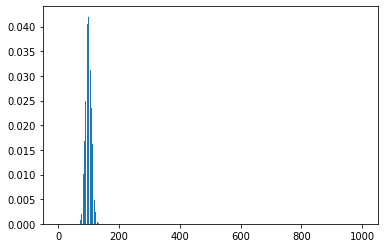

In [44]:
#Эту ситуацию описывает биномиальное распределение. Смоделируем его
p = 1/10
n = 1000

distr = []

for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n-k))
    prob = choose * p**k * (1 - p)**(n - k) 
    distr.append(prob)

probability_more_than_100 = sum(distr[100:])
    
plt.bar(range(0, n + 1), distr);
print(f"Вероятность получения более как минимум 100 успехов: {probability_more_than_100:.4f}")

In [45]:
# 51% - очень мало. Так задача будет провалена, ведь нам нужно как минимум 95% увеленности в том, что как минимум 100 человек продлят подписку.
#Количество промокодов должно вырасти. Подберем ниже оптимальный вариант.

import scipy.stats as stats

p_success = 0.1
min_successes = 100
minimum_level = 0.95

n = 1000
while True:
    probability = 1 - stats.binom.cdf(min_successes - 1, n, p_success)
    if probability >= minimum_level:
        break
    n += 1

print(f"Минимальное количество испытаний: {n}")


Минимальное количество испытаний: 1161


Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации построим примерный график распределения и оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.


In [46]:
#Заменим это биномиальное рапределение нормальным, так как вероятность довольно большая
from math import sqrt
from scipy import stats as st

# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399 500
result = distr.cdf(399500)
print("Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей:", result)

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей: 0.15371708296369768


**Общий вывод**

Для анализа были получены 3 датасета: с информацией о пользователях, подписках и типах подписок на сервис аренды самокатов GoFast.
В результате предобработки были удалены дубликаты и изменен тип столбца с датами на datetime64.

После проведения исследовательского анализа данных стало понятно, что:

- Больше всего пользователей в Пятигорске (219) и меньше всего в Москве (168), а всего городов, где используется сервис, 8: Тюмень, Омск, Москва, Ростов-на-Дону, Краснодар, Пятигорск, Екатеринбург, Сочи.

- Пользователей с подпиской больше, чем без подписки: 835 с подпиской, 699 без подписки.

- Больше всего клиентов в возрасте от 20 до 30 лет. Меньше всего самых взрослых и самых молодых: до 15 и от 37 до 43.

- Аномалий среди данных о расстоянии и продолжительности нет.

После проведения анализа можно сделать вывод, что:

- что пользователи с подпиской в среднем тратят больше времени на поездки: 18.54 VS 17.39 минут.

-  среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров. В частности, около 3115 метров.

- помесячная выручка от пользователей с подпиской будет выше (около 363 рублей), чем от пользователей без подписки (около 329 рублей).


После анализа распределений, можно сказать, что чтобы как минимум 100 человек оформило платную подписку после использования промокода, а это происходит с вероятностью в 10%, нужно выслать как минимум 1161 промокод.

А также, если разослать клиентам 1 млн уведомлений, и уже известно, что только 40% их откроет, то вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, составляет 15%.

Также можно порекомендовать бизнесу стимулировать приобретение пользователями подписок, сосредоточиться на пользователях от 20 до 30 лет и что можно рассмотреть добавление станций рядом с остановками общественного транспорта.